In [1]:
! pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 41.4 MB/s 


Imports:

In [3]:
import numpy as np
from matplotlib import cm as CM
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy.io as io
from PIL import Image
import PIL
import h5py
import os
import glob
import cv2
import random
import math
import sys
import itertools

Downloading the dataset:

In [5]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [6]:
! kaggle datasets download -d tthien/shanghaitech-with-people-density-map

100% 4.78G/4.79G [02:05<00:00, 49.0MB/s]
100% 4.79G/4.79G [02:05<00:00, 41.0MB/s]


In [7]:
! unzip "/content/shanghaitech-with-people-density-map.zip"

Streaming output truncated to the last 5000 lines.
  inflating: ShanghaiTech/part_B/test_data/images/IMG_199.jpg  
  inflating: ShanghaiTech/part_B/test_data/images/IMG_2.jpg  
  inflating: ShanghaiTech/part_B/test_data/images/IMG_20.jpg  
  inflating: ShanghaiTech/part_B/test_data/images/IMG_200.jpg  
  inflating: ShanghaiTech/part_B/test_data/images/IMG_201.jpg  
  inflating: ShanghaiTech/part_B/test_data/images/IMG_202.jpg  
  inflating: ShanghaiTech/part_B/test_data/images/IMG_203.jpg  
  inflating: ShanghaiTech/part_B/test_data/images/IMG_204.jpg  
  inflating: ShanghaiTech/part_B/test_data/images/IMG_205.jpg  
  inflating: ShanghaiTech/part_B/test_data/images/IMG_206.jpg  
  inflating: ShanghaiTech/part_B/test_data/images/IMG_207.jpg  
  inflating: ShanghaiTech/part_B/test_data/images/IMG_208.jpg  
  inflating: ShanghaiTech/part_B/test_data/images/IMG_209.jpg  
  inflating: ShanghaiTech/part_B/test_data/images/IMG_21.jpg  
  inflating: ShanghaiTech/part_B/test_data/images/IMG_210

Loading the dataset:

In [8]:
train_path_list = []
test_path_list = []

def get_map(file_path):
    grtr_file = h5py.File(file_path, 'r')
    groundtruth = np.asarray(grtr_file['density'])
    groundtruth = np.expand_dims(groundtruth, axis=-1)
    return groundtruth

root = '/content/ShanghaiTech/'
train_A = root + 'part_A/train_data/images'
test_A = root + 'part_A/test_data/images'

train_B = root + 'part_B/train_data/images'
test_B = root + 'part_B/test_data/images'


# for path in glob.glob(os.path.join(train_A, '*.jpg')):
#     train_path_list.append(str(path))
        
# for path in glob.glob(os.path.join(test_A, '*.jpg')):
#     test_path_list.append(str(path))

for path in glob.glob(os.path.join(train_B, '*.jpg')):
    train_path_list.append(str(path))

for path in glob.glob(os.path.join(test_B, '*.jpg')):
    test_path_list.append(str(path))

grtr_train_pathlist = [path.replace('jpg', 'h5').replace('images', 'ground-truth-h5') for path in train_path_list]
grtr_test_pathlist = [path.replace('jpg', 'h5').replace('images', 'ground-truth-h5') for path in test_path_list]

train_labels = np.array([get_map(path) for path in grtr_train_pathlist]).astype('float16')
test_labels = np.array([get_map(path) for path in grtr_test_pathlist]).astype('float16')

**Data Generator:**(Copied from Stackoverflow)

In [9]:
import tensorflow as tf
import tensorflow.keras
import tensorflow_addons as tfa
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K
from tensorflow.keras.losses import *
from tensorflow.keras.mixed_precision import experimental as mixed_precision
from tensorflow.keras.regularizers import l1_l2
from tensorflow.python.client import device_lib

policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

target_type=tf.dtypes.float16
def load_img(path):
    image_string=tf.io.read_file(path)
    image=tf.image.decode_jpeg(image_string,channels=3)
    image=tf.image.convert_image_dtype(image, target_type)
    return image

def gen_downsampling_func(downsampling, method='nearest', batch=True):
    batchadd=1
    if batch==False:
        batchadd=0
    @tf.function
    def _downsampling_function_(img, gth):
        down_ratio=downsampling
        before_resize=tf.reduce_sum(gth)
        gth_shape=tf.shape(gth)
        out_gth=tf.image.resize(gth, (gth_shape[0+batchadd]//down_ratio, gth_shape[1+batchadd]//down_ratio), method=method,antialias=False)
        out_gth=tf.cast(out_gth, dtype=target_type)
        after_resize=tf.reduce_sum(out_gth)
        if (before_resize >= 0.3) and (after_resize > 0.01):
            out_gth=out_gth * before_resize / after_resize
        return img, out_gth
    return _downsampling_function_

def gen_randomcrop_func(crop_size, batch=True):
    batchadd=1
    if batch==False:
        batchadd=0
    @tf.function
    def _random_crop_(img, gth):
        output_shape=tf.constant(crop_size)
        img_shape=tf.shape(img)

        ratio_x=tf.random.uniform((1,), minval=0, maxval=img_shape[1+batchadd]-output_shape[1], dtype=tf.dtypes.int32)[0]
        ratio_y=tf.random.uniform((1,), minval=0, maxval=img_shape[0+batchadd]-output_shape[0], dtype=tf.dtypes.int32)[0]

        out_img=tf.image.crop_to_bounding_box(img, ratio_y, ratio_x, output_shape[0], output_shape[1])
        out_gth=tf.image.crop_to_bounding_box(gth, ratio_y, ratio_x, output_shape[0], output_shape[1])

        return out_img, out_gth
    return _random_crop_
        

def basic_dataset(img_data, label_data, batch_size=1, flip=False, downsampling=1, buffer_size=32, shuffle=False):
    input_data=tf.data.Dataset.from_tensor_slices(img_data)
    input_data = input_data.map(load_img)
    output_data=tf.data.Dataset.from_tensor_slices(label_data)

    if flip:
        input_data=input_data.concatenate(input_data.map(tf.image.flip_left_right))
        output_data=output_data.concatenate(output_data.map(tf.image.flip_left_right))

    dataset=tf.data.Dataset.zip((input_data, output_data))
    if shuffle:
        dataset = dataset.batch(batch_size).repeat().shuffle(buffer_size=buffer_size, reshuffle_each_iteration=True)
    else:
        dataset = dataset.batch(batch_size).repeat()

    if downsampling!=1:
        dataset=dataset.map(gen_downsampling_func(downsampling=downsampling))
    return dataset

def crop_dataset(img_data, label_data, crop_size, flip, downsampling, batch_size=1, sample_method='bicubic', buffer_size=16):
    dataset = basic_dataset(img_data, label_data, flip=flip, batch_size=batch_size, downsampling=1, shuffle=True, buffer_size=buffer_size)
    dataset=dataset.map(gen_randomcrop_func(crop_size))
    
    if downsampling!=1:
        dataset=dataset.map(gen_downsampling_func(downsampling=downsampling, method=sample_method))
    return dataset

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5
Instructions for updating:
Use tf.keras.mixed_precision.LossScaleOptimizer instead. LossScaleOptimizer now has all the functionality of DynamicLossScale


Building the model:

In [10]:
from keras.engine.input_layer import InputLayer
from tensorflow import keras
from keras import layers, models

def add_10vgg():
    vgg16 = VGG16(weights='imagenet', include_top=False)
    vgg16.trainable=False

    firstIt = True
    count = 0
    for layer in vgg16.layers:
        layer.trainable = False

        if firstIt:
          lay = layer
          firstIt = False
        else:
          lay = layer(lay)

        if 'conv' in layer.name:
            count+=1
        if count == 10:
            break;
        return lay

def get_model():
    reg = (0.0,0.0)
    dilations = [2,2,2,2,2,2]
    dtype = tf.dtypes.float16

    init = RandomNormal(stddev=0.01)
    model = models.Sequential()

    input_layer = Input(shape=(None, None, 3))

    model.add(input_layer)
    
    lay = Lambda(lambda batch: (batch - tf.constant([0.485,0.456,0.406], dtype=dtype)) / tf.constant([0.229,0.224,0.225],dtype=dtype))

    model.add(lay)

    vgg16 = VGG16(weights='imagenet', include_top=False)
    vgg16.trainable=False

    count = 0
    for layer in vgg16.layers:
        layer.trainable = False
        model.add(layer)

        if 'conv' in layer.name:
            count+=1
        if count == 10:
            break;
            
    # lays = add_10vgg()
    # model.add(lays)

    model.add(BatchNormalization())
    
    model.add(Conv2D(filters=512, kernel_size=(3, 3), dilation_rate=dilations[0], padding='same', use_bias=False, kernel_initializer=init, kernel_regularizer=l1_l2(l1=reg[0], l2=reg[1])))
    model.add(BatchNormalization())
    model.add(Activation(tf.nn.relu))
    
    model.add(Conv2D(filters=512, kernel_size=(3, 3), dilation_rate=dilations[1], padding='same', use_bias=False, kernel_initializer=init, kernel_regularizer=l1_l2(l1=reg[0], l2=reg[1])))
    model.add(BatchNormalization())
    model.add(Activation(tf.nn.relu))
    
    model.add(Conv2D(filters=512, kernel_size=(3, 3), dilation_rate=dilations[2], padding='same', use_bias=False, kernel_initializer=init, kernel_regularizer=l1_l2(l1=reg[0], l2=reg[1])))
    model.add(BatchNormalization())
    model.add(Activation(tf.nn.relu))
    
    model.add(Conv2D(filters=256, kernel_size=(3, 3), dilation_rate=dilations[3], padding='same', use_bias=False, kernel_initializer=init, kernel_regularizer=l1_l2(l1=reg[0], l2=reg[1])))
    model.add(BatchNormalization())
    model.add(Activation(tf.nn.relu))
    
    model.add(Conv2D(filters=128, kernel_size=(3, 3), dilation_rate=dilations[4], padding='same', use_bias=False, kernel_initializer=init, kernel_regularizer=l1_l2(l1=reg[0], l2=reg[1])))
    model.add(BatchNormalization())
    model.add(Activation(tf.nn.relu))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), dilation_rate=dilations[5], padding='same', use_bias=False, kernel_initializer=init, kernel_regularizer=l1_l2(l1=reg[0], l2=reg[1])))
    model.add(BatchNormalization())
    model.add(Activation(tf.nn.relu))
         
    model.add(Conv2D(filters=1, kernel_size=(1, 1), dilation_rate=1, padding='same', use_bias=True, kernel_initializer=init))
    model.add(Activation(tf.math.sigmoid))
    
    return model

Training:

In [11]:
def density_mae(y_truth, y_pred):
    return tf.reduce_mean(tf.abs(tf.reduce_sum(y_truth, axis=(1,2,3))-tf.reduce_sum(y_pred, axis=(1,2,3))))

batch_size=8
train_len=320

val_gen = basic_dataset(train_path_list[train_len:], train_labels[train_len:], batch_size=1, flip=False, downsampling=8, buffer_size=16, shuffle=False)
test_gen = basic_dataset(test_path_list, test_labels, batch_size=1, flip=False, downsampling=8, buffer_size=16, shuffle=False)
train_gen  = crop_dataset(train_path_list[:train_len], train_labels[:train_len], crop_size=(760,1000), flip=True, downsampling=8, batch_size=batch_size, sample_method='bicubic', buffer_size=8)

reduceLR=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_density_mae', factor=0.5, patience=5, verbose=1, min_delta=1e-8)
earlyStop=tf.keras.callbacks.EarlyStopping(monitor='val_density_mae', patience=25, verbose=1, restore_best_weights=True)

model = get_model()
model.summary()

history = model.compile(optimizer=RMSprop(lr=1e-4, momentum=0.7, decay=0.0001), loss='binary_crossentropy', metrics=[density_mae])
model.build(input_shape=(None, None, None, 3))


model.fit(train_gen, steps_per_epoch=int(train_len*2/batch_size), epochs=80, verbose=1, use_multiprocessing=True,
              max_queue_size=32, workers=6, validation_data=val_gen, validation_steps=80, callbacks=[earlyStop, reduceLR])

model.evaluate(val_gen, steps=80, verbose=1, workers=4)
model.evaluate(test_gen, steps=316, verbose=1, workers=4)


58900480/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, None, None, 3)     0         
                                                                 
 input_2 (InputLayer)        multiple                  0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                         

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/80
80/80 [==============================] - 108s 753ms/step - loss: 0.4853 - density_mae: 4381.0532 - val_loss: 0.5509 - val_density_mae: 5052.3301 - lr: 1.0000e-04
Epoch 2/80
80/80 [==============================] - 58s 730ms/step - loss: 0.2359 - density_mae: 2261.7317 - val_loss: 0.3001 - val_density_mae: 2985.8650 - lr: 1.0000e-04
Epoch 3/80
80/80 [==============================] - 59s 733ms/step - loss: 0.1133 - density_mae: 979.8260 - val_loss: 0.1190 - val_density_mae: 1075.5563 - lr: 1.0000e-04
Epoch 4/80
80/80 [==============================] - 59s 734ms/step - loss: 0.0619 - density_mae: 360.6348 - val_loss: 0.0578 - val_density_mae: 338.7374 - lr: 1.0000e-04
Epoch 5/80
80/80 [==============================] - 59s 733ms/step - loss: 0.0434 - density_mae: 116.5277 - val_loss: 0.0402 - val_density_mae: 57.3577 - lr: 1.0000e-04
Epoch 6/80
80/80 [==============================] - 59s 732ms/step - loss: 0.0377 - density_mae: 42.2765 - val_loss: 0.0370 - val_density_mae: 21

[0.035601772367954254, 13.154010772705078]

Plotting the history:

In [ ]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([np.min(history.history['lr']), np.max(history.history['lr']), np.min(history.history['loss']), 15])
plt.show()

Loading trained model:

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/model')

In [13]:
def haar_face_detector(image):
  hog = cv2.HOGDescriptor()
  hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

  height, width = image.shape[:2]

  face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + '/haarcascade_frontalface_default.xml')

  gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
  gray = np.array(gray, dtype='uint8')

  min_size = int(max(0.005*width, 0.005*height))
  bboxes = face_cascade.detectMultiScale(gray,
                                        scaleFactor=1.1,
                                        minNeighbors=2,
                                        minSize=(min_size, min_size))
    
  for (x, y, w, h) in bboxes:
      image = cv2.rectangle(image, (x, y), 
                    (x + w, y + h), 
                    (255, 0, 0), 2)
      
  return image, len(bboxes)

In [14]:
import pickle
import imutils

def sliding_window(image, stepSize, windowSize):
  for y in range(0, image.shape[0], stepSize):
    for x in range(0, image.shape[1], stepSize):
      yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

def pyramid(image, scale=1.4, minSize=(32, 32)):
    yield image 

    while True:
        w = int(image.shape[1] / scale)     
        image = imutils.resize(image, width=w)

        if image.shape[0] < minSize[1] or image.shape[1] > minSize[0]:
            break 
        yield image

def HOG_face_detector(image, model):
  bboxes = []
  (winW, winH) = (128, 128)

  image = skimage.color.rgb2gray(image)

  for resized in pyramid(image, scale=1.4):
    for (x, y, window) in sliding_window(resized, stepSize=32, windowSize=(winW, winH)):
      if window.shape[0] != winH or window.shape[1] != winW: continue
      fd = feature.hog(window)
      pred = model.predict([fd])
      
      if pred==1:
        bboxes.append((x, y, winW, winH))
        
      clone = resized.copy()
      cv2.rectangle(clone, (x, y), (x + winW, y + winH), (0, 255, 0), 2)
      cv2_imshow(clone)
      cv2.waitKey(1)


  for(x, y, w, h) in bboxes:
    image = cv2.rectangle(image, (x, y), 
                      (x + w, y + h), 
                      (255, 0, 0), 2)  
  return image, len(bboxes)

Visualization:

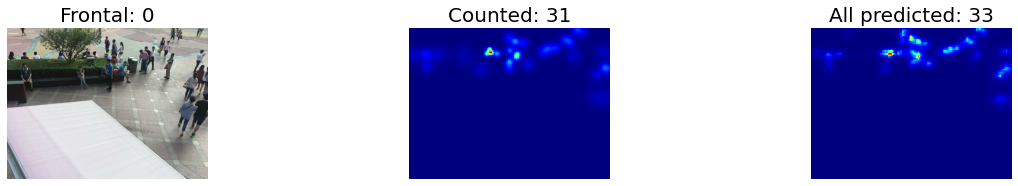

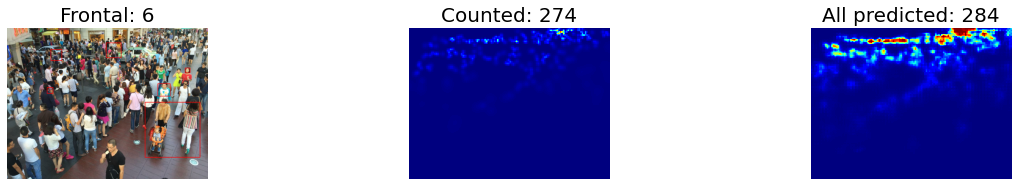

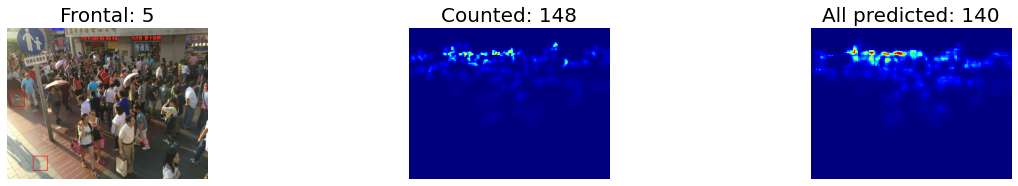

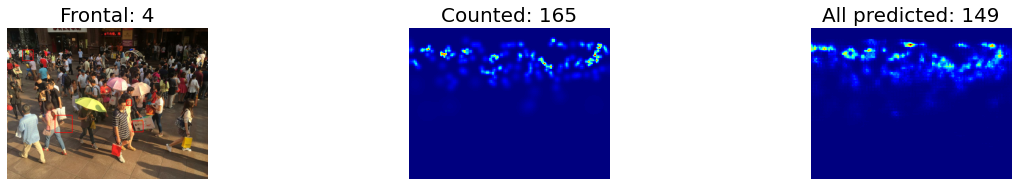

In [15]:
# Copied from :

def show_images(images, cols = 2, titles = None, padding=1, axis="off", channel1=CM.jet):
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = [None for i in range(1,n_images + 1)]
    fig = plt.figure()
    
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)

        plt.axis(axis)
        plt.subplots_adjust(wspace=padding, hspace=padding)

        if (image.shape[2] == 1):
            image = image[:,:,0]
            plt.imshow(image, cmap=channel1)
        elif np.any(image > 1.0):
            plt.imshow(image / 255.0)
        else:
            plt.imshow(image)
        a.set_title(title, fontsize=20)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()


for a,b in test_gen.take(4):
    c = model.predict(a)
    a_1 = np.squeeze(np.float32(a*255))
    a = tf.cast(a, dtype=tf.dtypes.float32)
    b = tf.cast(b, dtype=tf.dtypes.float32)
    c = c.astype('float32')

    pic, face_num = haar_face_detector(a_1)

    #model = pickle.load(open('SVMmodel.sav', 'rb'))
    #pic, face_num = HOG_face_detector(a_1, model)

    show_images([pic, b[0], c[0]], 1, 
                ['Frontal: '+str(face_num), 'Counted: ' + str(round(np.sum(b[0]))),
                 'All predicted: '+ str(round(np.sum(c[0])))])

Saving trained model:

In [16]:
model.save('/content/drive/MyDrive/model2')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/model2/assets


In [28]:
def load_img(path):
    image_string=tf.io.read_file(path)
    image=tf.image.decode_jpeg(image_string,channels=3)
    image=tf.image.convert_image_dtype(image, target_type)
    return image

filePath = '/content/drive/MyDrive/Dataset'

test_list = []

for path in glob.glob(os.path.join(filePath, '*.jpg')):
    test_list.append(str(path))

counted_list = []

with open('/content/drive/MyDrive/Dataset/Labels.txt') as f:
  lines = f.readlines()

for line in lines:
  counted_list.append(int(line))

f.close()

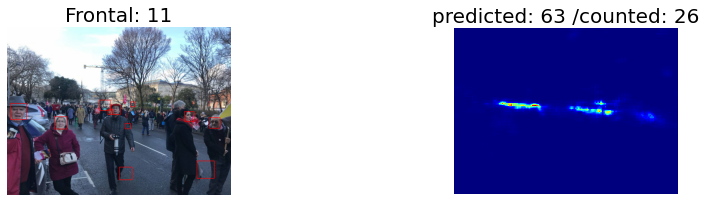

In [47]:
i = 140

image = load_img(test_list[i])
image2 = load_img(test_list[i])
image = tf.expand_dims(image, axis=0)

c = model.predict(image)
a_1 = np.squeeze(np.float32(image2*255))
c = c.astype('float32')

pic, face_num = haar_face_detector(a_1)

#model = pickle.load(open('SVMmodel.sav', 'rb'))
#pic, face_num = HOG_face_detector(a_1, model)

show_images([pic, c[0]], 1, 
            ['Frontal: '+str(face_num),
              'predicted: '+ str(round(np.sum(c[0])))+ ' /counted: '+ str(counted_list[i])])